# Introduction

In this notebook, we will be going through the process of using the ReLeaSE algorithm (see reference below) and how we used quantum computing to (possibly) enhance it. The ReLeaSE algorithm consists of two main parts, the generator and the predictor. For this notebook, we will show how we implemented a quantum generator using QGRU, and show the training process. What you will notice is that the process would be remarkably similar, as we have taken care to streamline it so that it follows the conventions of PyTorch as much as possible.

As for the predictor, we will be using a classical one, but you can find that we have studied quantum approaches for it in other parts of the GitLab, using Quantum Transfer Learning and Quanvolutional NNs.

**Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 


# Import libraries and modules

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

In [4]:
sys.path.append('./release/')

In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

In [6]:
use_cuda = torch.cuda.is_available()

C:\Users\jonas\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import Descriptors
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils_2 import canonical_smiles

C:\Users\jonas\Anaconda3\envs\my-rdkit-env\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Generator

The original ReLeaSE algorithm utilized a stack-augmented RNN technique that can use either Long Short Term Memory (LSTM) or GRU for their generative model. In an earlier project that won an award in QHACK, SoftServe had showcased a version of LSTM called QLSTM using quantum variational layers to improve on the original LSTM. In this particular project, we show that we can use similar principles to improve GRU to get QGRU.

GRU (including QGRU) and LSTM are RNN techniques, which are widely used for many tasks that involves sequential data. It works by utilizing some of the neural network layers to form a loop, attaching more importance the sequence of items rather than the individual items themselves.  They are used quite widely for time series data, audio data, and in our case, a type of Natural Language Processing data. Being a representation of molecules, the sequence of the individual elements are as important if not more important than just what elements are inside the molecule, making the RNN techniques suitable for our generator

## Data and data processing

This data was tailored for this proof-of-concept to have just enough data points to maintain diversity for the generator, while still ensuring that there's not too much data such that it becomes inefficient for training. We selected about 1000 different SMILES of varying length up to 30, all using elements created using the below tokens. 

The below code stores the data in a class to make it easy for the rest of the code to access and sample from it.

In [9]:
gen_data_path = './data/logP_red_3.smi'

In [10]:
tokens = ["<", ">", "0", "1", "2", "3", "4", "#", "=", "[", "]", 
         "(", ")", "H", "C", "N", "O", "P", "S", "a", "F", "l", "B", "r", "I", "Y"]

In [11]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens, pad_symbol='Y')

## Training the generator

Before training the generator, we have to decide some of its parameters and hyperparameters. Here are some of the details:

- Layer Type: Perhaps the most important parameter to this notebook. One can use "GRU", "LSTM", or "QGRU" as layer type, of which the former two are classical RNN techniques, while the last one is the Quantum GRU which uses Pennylane. Furthermore, while unlikely, one can also specify the backend that one wants to use supposing QGRU is chosen.

- Hidden size: Each RNN has a hidden state acts as a memory unit. The hidden size reflects the number of features stored for the hidden state.

- Stack width and depth: Part of the stack augmented RNN. A single layer RNN Cell (be it GRU or LSTM or QGRU) is often not complex enough to capture and "memorize" the structure of the data, which can be overcome by stacking them to incrase model complexity. These two parameters capture that (performs similar function to n_layers in a GRU from Pytorch

- Optimizer: Use any optimizer you wish, we used Adadelta. LR stands for learning rate, and is a pretty self-explanatory hyper-parameter. Generally for quantum ones you want it to be higher (0.01 - 0.05), while classical ones you want to be lower (around 0.001).

We make sure to save the model in the below model_path variable. We can comment out the training if we want to just run the model we saved.


In [12]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [13]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr, ignore_idx = gen_data.pad_symbol_idx)

In [14]:
losses = my_generator.fit(gen_data, 20, 2000)

Training in progress...:   5%|▍         | 99/2000 [07:31<2:16:42,  4.31s/it]

 35s (100 5%) 2.2666]


Training in progress...:   5%|▌         | 100/2000 [07:36<2:22:42,  4.51s/it]

['<2Na)<Y1#4P4Fr>'] 



Training in progress...:  10%|▉         | 199/2000 [15:51<2:29:15,  4.97s/it]

 55s (200 10%) 1.5671]


Training in progress...:  10%|█         | 200/2000 [15:56<2:27:56,  4.93s/it]

['<(B)S)NaO0O(0IPNF(FllHl[#H(2>'] 



Training in progress...:  15%|█▍        | 299/2000 [25:29<2:49:31,  5.98s/it]

 35s (300 15%) 1.7393]


Training in progress...:  15%|█▌        | 300/2000 [25:36<2:59:12,  6.33s/it]

['<CCC1C=CCCC1>'] 



Training in progress...:  20%|█▉        | 399/2000 [35:29<2:34:19,  5.78s/it]

 35s (400 20%) 1.5235]


Training in progress...:  20%|██        | 400/2000 [35:37<2:50:44,  6.40s/it]

['<CY1>'] 



Training in progress...:  25%|██▍       | 499/2000 [46:14<2:15:53,  5.43s/it]

 19s (500 25%) 1.3547]


Training in progress...:  25%|██▌       | 500/2000 [46:20<2:21:04,  5.64s/it]

['<ClC(O)I=O)C=C1)CC=CC1S=CC1=C1>'] 



Training in progress...:  30%|██▉       | 599/2000 [55:14<2:12:13,  5.66s/it]

 19s (600 30%) 1.4985]


Training in progress...:  30%|███       | 600/2000 [55:20<2:16:00,  5.83s/it]

['<C()O=CC1>'] 



Training in progress...:  35%|███▍      | 699/2000 [1:04:13<1:58:15,  5.45s/it]

 20s (700 35%) 1.7499]


Training in progress...:  35%|███▌      | 700/2000 [1:04:21<2:12:46,  6.13s/it]

['<COCC1O>'] 



Training in progress...:  40%|███▉      | 799/2000 [1:13:11<1:55:49,  5.79s/it]

 16s (800 40%) 1.2476]


Training in progress...:  40%|████      | 800/2000 [1:13:16<1:56:23,  5.82s/it]

['<CCC(=O)C(=O)=O>'] 



Training in progress...:  45%|████▍     | 899/2000 [1:21:54<1:39:30,  5.42s/it]

 0s (900 45%) 1.4551]


Training in progress...:  45%|████▌     | 900/2000 [1:22:01<1:47:12,  5.85s/it]

['<C1=CCC=CC2C1=C=Cl)CC=C1>'] 



Training in progress...:  50%|████▉     | 999/2000 [1:30:57<1:25:53,  5.15s/it]

 3s (1000 50%) 1.1955]


Training in progress...:  50%|█████     | 1000/2000 [1:31:03<1:31:01,  5.46s/it]

['<F=CC1>'] 



Training in progress...:  55%|█████▍    | 1099/2000 [1:39:45<1:16:25,  5.09s/it]

 51s (1100 55%) 1.2125]


Training in progress...:  55%|█████▌    | 1100/2000 [1:39:52<1:23:01,  5.54s/it]

['<CCCCCCC=C1>'] 



Training in progress...:  60%|█████▉    | 1199/2000 [1:48:41<1:05:01,  4.87s/it]

 46s (1200 60%) 1.1321]


Training in progress...:  60%|██████    | 1200/2000 [1:48:47<1:09:45,  5.23s/it]

['<O4rBr>'] 



Training in progress...:  65%|██████▍   | 1299/2000 [1:58:02<57:41,  4.94s/it]  

 7s (1300 65%) 1.2490]


Training in progress...:  65%|██████▌   | 1300/2000 [1:58:07<1:00:45,  5.21s/it]

['<2=C1=CCC1CC=C=CC1=O>'] 



Training in progress...:  70%|██████▉   | 1399/2000 [2:07:09<54:24,  5.43s/it]  

 14s (1400 70%) 1.1305]


Training in progress...:  70%|███████   | 1400/2000 [2:07:15<56:12,  5.62s/it]

['<1aHOCC=CCC=C1>'] 



Training in progress...:  75%|███████▍  | 1499/2000 [2:16:01<44:52,  5.37s/it]

 6s (1500 75%) 1.2077]


Training in progress...:  75%|███████▌  | 1500/2000 [2:16:07<46:58,  5.64s/it]

['<CN(=O)=CF=C1>'] 



Training in progress...:  80%|███████▉  | 1599/2000 [2:25:45<42:42,  6.39s/it]  

 52s (1600 80%) 1.1509]


Training in progress...:  80%|████████  | 1600/2000 [2:25:53<44:57,  6.74s/it]

['<O=C1=CC=C(=O)CS1>'] 



Training in progress...:  85%|████████▍ | 1699/2000 [2:36:32<32:12,  6.42s/it]

 38s (1700 85%) 1.1107]


Training in progress...:  85%|████████▌ | 1700/2000 [2:36:39<33:00,  6.60s/it]

['<BCN=C1l>'] 



Training in progress...:  90%|████████▉ | 1799/2000 [2:46:55<23:40,  7.07s/it]

 2s (1800 90%) 1.0980]


Training in progress...:  90%|█████████ | 1800/2000 [2:47:03<24:19,  7.30s/it]

['<CN(O)C=C1C>'] 



Training in progress...:  95%|█████████▍| 1899/2000 [2:56:02<07:31,  4.47s/it]

 7s (1900 95%) 1.0236]


Training in progress...:  95%|█████████▌| 1900/2000 [2:56:08<07:57,  4.78s/it]

['<CCCC=CCO>'] 



Training in progress...: 100%|█████████▉| 1999/2000 [3:04:54<00:05,  5.61s/it]

 59s (2000 100%) 1.0669]


Training in progress...: 100%|██████████| 2000/2000 [3:05:00<00:00,  5.55s/it]

['<CN=CC=C(=S)N1>'] 



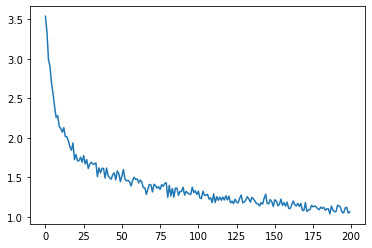

In [15]:
plt.plot(losses)

In [16]:
my_generator.save_model(model_path)

If you want to just load a model that has already been trained, just run the code cell below and comment out the above 3 cells.

In [17]:
my_generator.load_model(model_path)

## Testing the generator

In the following code, we test the generator by seeing how many valid SMILES it can generate. We use a sample size of a 1000 (Batch size 10, with a 100 iterations). 

Following that, we also determine the molecular weight, and store the 80th percentile (can be changed). This is to set up for the reward later as we want to have SMILES with a greater molecular weights (as they will be longer in general).

In [18]:
n_generate = 100
batch_s = 10

def estimate(generator, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, batch_size = batch_s))
        
    return generated

def clean_generated(gen):
    gen_size = len(gen)
    batch_size = len(gen[0])
    
    gen_clean = []
    
    for i in range(gen_size):
        new = []
        for j in range(batch_size):
            new.append(gen[i][j][1:-1])
        gen_clean.append(new)
    
    return gen_clean
            

In [19]:
gen = estimate(my_generator, n_to_generate = n_generate)

Generating molecules...: 100%|██████████| 100/100 [05:25<00:00,  3.26s/it]


In [20]:
new_san = []

for i in range(n_generate):
    sanitized = canonical_smiles(clean_generated(gen)[i], sanitize=False, throw_warning=False)
    for j in range(batch_s):
        if sanitized[j] != '':
            new_san.append(sanitized[j])
             
new_san

['CCOCOCCOC',
 'CC(Cl)Cl',
 'ClC1(Cl)=[SH]CCOCCCCC1',
 'CC=C(CO)NC=Cl',
 'CC(O)=C(C)(C)Cl',
 'CC(=O)=O',
 'C=C(=O)C1CCC=C1CCC',
 'OCCC1=CC=C=C1O',
 'ClC1=CC=N1',
 'CCCCCCO',
 'CC1=ON=CCC1',
 'COBrCC=CC1=CSC=[SH]N1',
 'OCC(O)C1=CC=C=CC(O)C=1',
 'NCC(=O)NO',
 'CONBr',
 'OCCl',
 'CC=CC=C1C=CC=N1',
 'CCC(=O)COC',
 'CCCC',
 'C1=CC=CC=CC=C1',
 'CC',
 'F',
 'CCCCN=C(Cl)C=O',
 'C#CCC(C)(Cl)C(N)O',
 'OC1C=CC=CC=C1',
 'CC(=O)C(C)CCO',
 'CC(O)C(=O)O=O',
 'COO',
 'CCCCCCC',
 'NCN1=C=CN=C=C1',
 'CCCC(=N)(=O)Cl',
 'ClFC1=CC=CCC=1',
 'CC(=O)NCCI',
 'CCC=CC1=CC=C=C1',
 'CC1=NCC=CC=C1',
 'CCCC',
 'CSNC(=O)CC(C)=O',
 'CCC(=O)(=CNC)C(C)O',
 'CCC1=CC(Cl)C=C1',
 'COOC(C)C',
 'BCN=CC=NO',
 'CC(C)C=CCl',
 'CCC1=CCC=NC=C1',
 'CCCCC(C)S',
 'C1=CC=CCC=C1',
 'CC1=CC=C1N',
 'CN(=O)NC1=CC=C(Cl)C=C1',
 'C[SH]=CC=CCC=CC(C)N',
 'O=C1CCC=CC=CC=CC1O',
 'CC(O)CCCCCCBr',
 'OCN1=CC=CC=C1',
 'C#CCCC',
 'CCCC=C1C=CC1',
 'CC(Cl)Cl',
 'O=CC=C1CCSC1',
 'CNC(O)O',
 'CC1=C(C(=O)CC=N)C=C1',
 'CN(=O)CF',
 'O=CC(Cl)CCl',
 'CCC=CC(=

In [21]:
len(new_san)/(n_generate * batch_s)

0.343

In [22]:
gen_mol_weight = []
for i in new_san:
    mol = Chem.MolFromSmiles(i)
    if mol != None:
        molwt = Descriptors.ExactMolWt(mol)
        gen_mol_weight.append(molwt)
gen_mol_weight

[134.094294308,
 97.969005488,
 124.052429496,
 86.987576744,
 102.104465068,
 90.042927432,
 124.947625848,
 65.987242396,
 119.073499288,
 102.06807956,
 58.078250319999995,
 104.062600256,
 30.046950192,
 20.006228252,
 147.04509162,
 147.04509162,
 108.057514876,
 116.083729624,
 48.021129368,
 100.12520051199999,
 212.965061876,
 118.07825032,
 107.073499288,
 58.078250319999995,
 147.035399528,
 128.039277968,
 90.06807956,
 98.065143244,
 104.039277968,
 121.08914935199999,
 118.08162144799999,
 92.062600256,
 81.057849224,
 171.108170544,
 164.083729624,
 208.046277264,
 68.062600256,
 108.093900384,
 97.969005488,
 128.029585876,
 77.047678464,
 135.068413908,
 125.963920108,
 140.083729624,
 117.1153641,
 90.042927432,
 121.08914935199999,
 78.023627904,
 18.010564684,
 95.073499288,
 108.034192588,
 136.106356888,
 96.093900384,
 126.99555458399999,
 18.010564684,
 17.026549096,
 74.036779432,
 109.06399722399999,
 66.046950192,
 108.034192588,
 118.07825032,
 107.058243148,

(array([15., 13., 44., 62., 71., 24., 13.,  2.,  4.,  3.]),
 array([ 17.0265491 ,  41.12254675,  65.2185444 ,  89.31454204,
        113.41053969, 137.50653734, 161.60253499, 185.69853264,
        209.79453029, 233.89052794, 257.98652559]),
 <BarContainer object of 10 artists>)

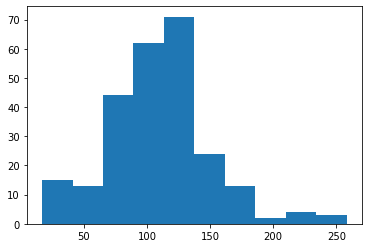

In [23]:
plt.hist(gen_mol_weight)

In [24]:
lower_weight = np.percentile(gen_mol_weight, 80)

# Predictor

In this particular Reinforcement Learning notebook, we use the classical predictor created for this project that the other quantum predictors are based on. This classical predictor takes in a SMILES input, and outputs a predicted value for LogP, an important value to determine the properties of the molecule.

Note that we are importing an already trained model, hence, if one wants to import a quantum trained (or another classical model), it is possible to do so too.

## Import the predictor

In [25]:
import os
import torch
from sklearn.metrics import r2_score
from modules.smiles import *
from predictor_logp import Predictor

In [26]:
kwargs = {}

path_to_model = 'models/model_best_test.pt'
#path_to_model = 'models/model_best_train.pt'
#path_to_model = 'models/model.pt'
path_to_dictionary = 'data/Dictionary'

predictor = torch.load(path_to_model)

In [27]:
predictor_tokens = tokens + [' ']

In [28]:
my_predictor = Predictor(predictor, predictor_tokens)

# Reinforcement Learning

In this part of the code, we perform the Reinforcement Learning on the generator that we had just trained (or imported), using the predictor to inform what properties the SMILES that were generated had. The RL algorithm that we use is a policy gradient one, where we continue training the generator with the results of the predictor to cause the generated molecules to tend towards a certain desired properties.

As mentioned previously, we care about the logP value, hence we have a logP predictor, but we also care about the length of the smile, which is related to the molecular weight (longer the SMILES, the more likely it is to be heavier), which in turn can be calculated as long as we know the elements of the SMILES (which we can compute). Thus, our reward value that we use for the RL process would reward logP being within a certain region (between 1 to 4), as well as reward a high molecular weight, making this a true multi-objective function.

## Define functions

These functions below perform the respective functions: 

Visualization functions:

- plot_hist: Basically shows histograms and values that we are interested in. This includes percentage of predictions within drug-like region (the logP values we want), proportion of valid SMILES and average Mol Weight.
- estimate_and_update: Generates SMILES using the generator, and uses the plot_hist function to update us on the progress.
- simple_moving_average: Self-explanatory. Used in the code later to visualize how reward and loss values change.

Reward functions:

- get_weight_reward: Gets the weight of the molecule, and checks whether it is higher than the lower limit we defined previously (80th percentile). 
- get_reward_logp: Gets the logP value as well as uses the get_weight_reward to check whether molecule both fits the logP requirement and molecule 

In [29]:
from reinforcement import Reinforcement

In [30]:
def plot_hist(smiles, prediction, n_to_generate, batch_size):
    prediction = prediction.detach().numpy()
    percentage_in_threshold = np.sum((prediction >= 1.0) & 
                                     (prediction <= 4.0))/len(prediction)
    
    gen_mol_weight = []
    for i in smiles:
        mol = Chem.MolFromSmiles(i)
        if mol != None:
            molwt = Descriptors.ExactMolWt(mol)
            gen_mol_weight.append(molwt)
    mean = np.percentile(gen_mol_weight, 50)
    
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/ (n_to_generate * batch_size))
    print("Average Mol Weight:", mean)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()
    
    return percentage_in_threshold, mean

In [31]:
def estimate_and_update(generator, predictor, n_to_generate, batch_size):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, batch_size = batch_size))
        
    new_san = []

    for i in range(n_to_generate):
        sanitized = canonical_smiles(clean_generated(generated)[i], sanitize=False, throw_warning=False)
        for j in range(batch_size):
            if sanitized[j] != '':
                new_san.append(sanitized[j])

    new_san

    #sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(new_san))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    p, w = plot_hist(smiles, torch.FloatTensor(prediction), n_to_generate, batch_size)
        
    return smiles, prediction, p, w 

In [32]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [33]:
def get_weight_reward(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is not None:
        molwt = Descriptors.ExactMolWt(mol)
        if lower_weight <= molwt:
            return 1
        else:
            return 0
    else:
        return 0

In [34]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    good_weight = get_weight_reward(smiles)
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0) and good_weight == 1:
        return 11.0
    else:
        return 1.0

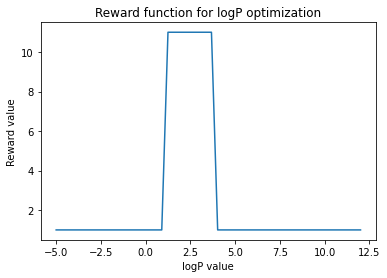

In [35]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

## Setting up the RL

To set up the RL, we define some parameters:

- n_iterations and n_policy:: How many times to run the policy gradient training (same meaning as epoch, i.e number of epochs is n_iterations multiplied with n_policy). At the end of every iteration we visualize the intermediate results. 
- n_to_generate and batch_s: Sample size for visualization at the end of every iteration (sample size = n_to_generate * batch_s)

In addition, we also make a copy of the generator to compare biased and unbiased.

In [37]:
# Setting up some parameters for the experiment
n_to_generate = 20
batch_s = 20
n_policy = 15
n_iterations = 20

We visualize the initial properties of the generated molecules of the unbiased (i.e have yet to go the RL process) generator:

Calculating predictions...: 100%|██████████| 128/128 [00:00<00:00, 775.66it/s]


Percentage of predictions within drug-like region: 0.45263157894736844
Proportion of valid SMILES: 0.2375
Average Mol Weight: 108.093900384


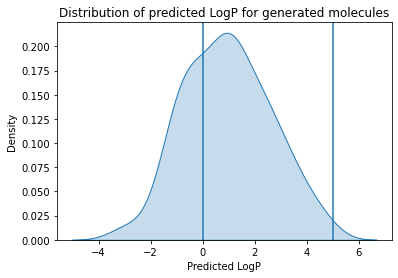

In [38]:
smiles_unbiased, prediction_unbiased, _ , _ = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=n_to_generate,
                                                           batch_size = batch_s)

We make a copy of the generator, and then run the RL process on it.

In [39]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr, ignore_idx = gen_data.pad_symbol_idx)

my_generator_max.load_model(model_path)

In [40]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [41]:
rewards = []
rl_losses = []

Policy Iteration: 0


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [11:31<00:00, 46.10s/it]


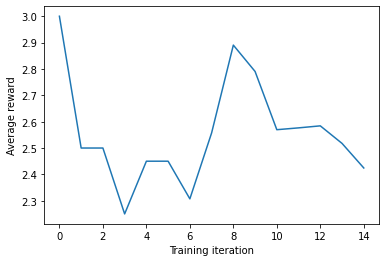

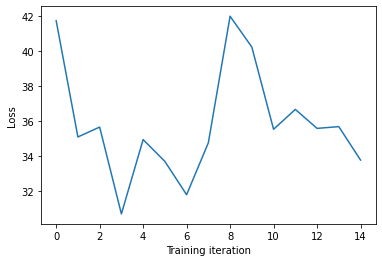

Calculating predictions...: 100%|██████████| 131/131 [00:00<00:00, 539.83it/s]


Percentage of predictions within drug-like region: 0.6236559139784946
Proportion of valid SMILES: 0.2325
Average Mol Weight: 123.068413908


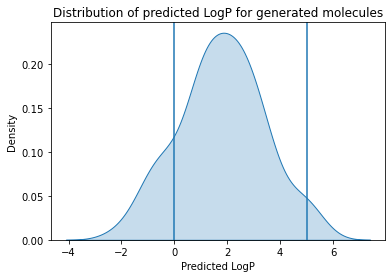

Sample trajectories:
C1=CSCN=C1              
C=C(C)C=COC             
C=C1C=CC=CC=C1          
C=C=C1C(=O)C1CC1=CCC=C1 
C=CC(C)OC               
Policy Iteration: 1


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [10:50<00:00, 43.36s/it]


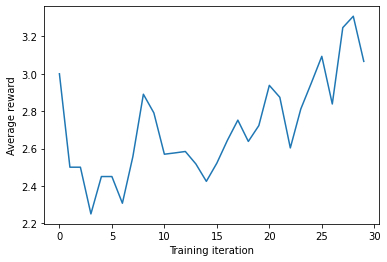

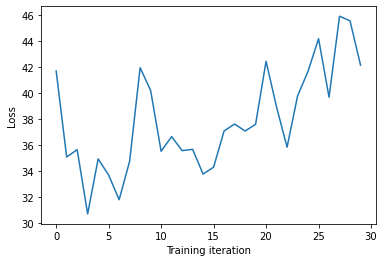

Calculating predictions...: 100%|██████████| 153/153 [00:00<00:00, 555.44it/s]


Percentage of predictions within drug-like region: 0.5555555555555556
Proportion of valid SMILES: 0.2925
Average Mol Weight: 139.136099544


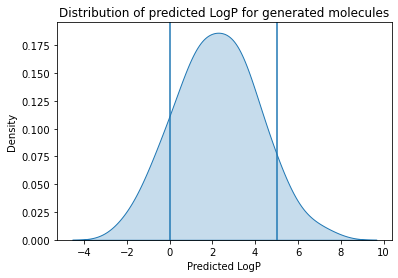

Sample trajectories:
C#CCC                    
C#CCCCC(C)CCCC           
C1=CCCCNCCCCC1           
C=CC(=O)O                
C=CCC(F)C=CN=O           
Policy Iteration: 2


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [10:33<00:00, 42.24s/it]


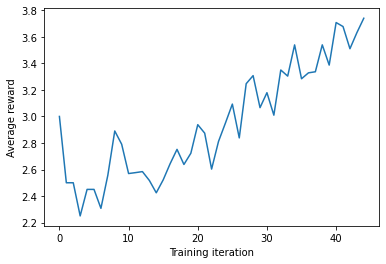

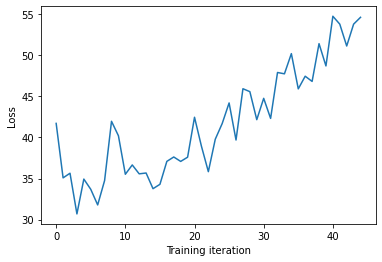

Calculating predictions...: 100%|██████████| 139/139 [00:00<00:00, 658.50it/s]


Percentage of predictions within drug-like region: 0.5585585585585585
Proportion of valid SMILES: 0.2775
Average Mol Weight: 170.203450832


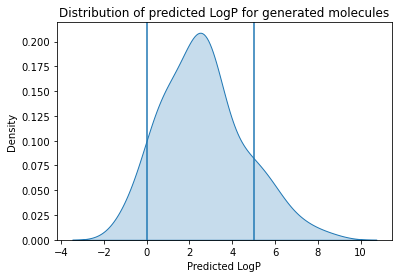

Sample trajectories:
C=C(CC)C(C)Cl                 
C=CCC=NO                      
C=CCCC=CC=O                   
C=CCCCCCCC(C)C(O)CCN          
C=[SH]C1=NC(=O)CCC1           
Policy Iteration: 3


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [11:35<00:00, 46.37s/it]


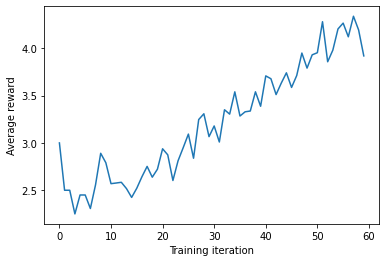

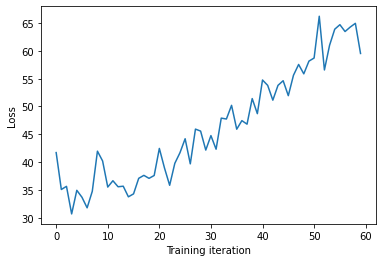

Calculating predictions...: 100%|██████████| 148/148 [00:00<00:00, 854.67it/s]


Percentage of predictions within drug-like region: 0.5377358490566038
Proportion of valid SMILES: 0.265
Average Mol Weight: 186.198365452


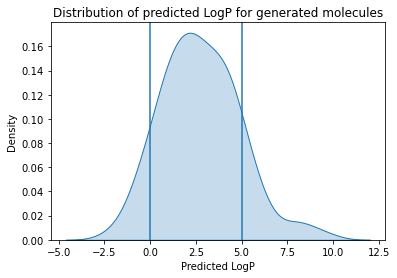

Sample trajectories:
C=C(C=CCBr)C(CS)CC(C)CC         
CC(=O)O                         
CC(C)CC(C)C=CCC=NCN             
CC(C)CCCC(C)CCSCCCC=O           
CC(C=CCCO)CC1=CC=CC=CC=CC=C1    
Policy Iteration: 4


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [10:02<00:00, 40.14s/it]


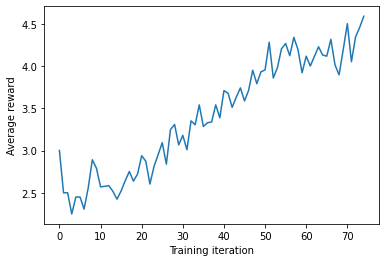

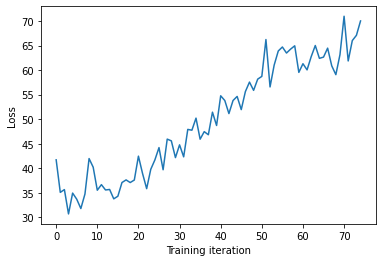

Calculating predictions...: 100%|██████████| 180/180 [00:00<00:00, 752.33it/s]


Percentage of predictions within drug-like region: 0.52
Proportion of valid SMILES: 0.375
Average Mol Weight: 189.149069532


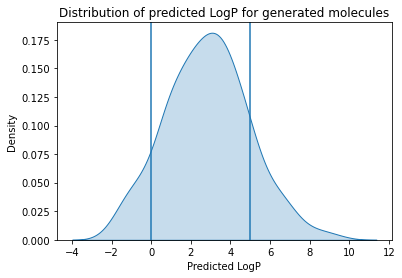

Sample trajectories:
C#CCCCCCC(O)CC(O)CCCCCC                 
C#CO                                    
C1=CC=NCCCCCCCN=C1                      
C=C(N)CC(F)(CCCN)NC                     
C=CCC(C)OCC                             
Policy Iteration: 5


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [08:25<00:00, 33.72s/it]


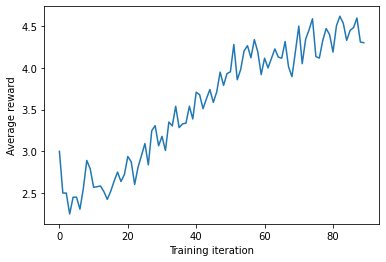

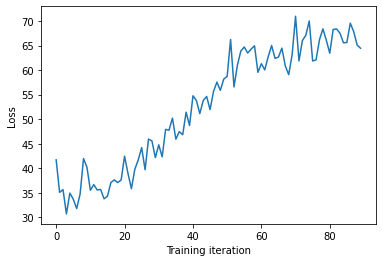

Calculating predictions...: 100%|██████████| 198/198 [00:00<00:00, 825.35it/s]


Percentage of predictions within drug-like region: 0.5178571428571429
Proportion of valid SMILES: 0.42
Average Mol Weight: 172.16452263399998


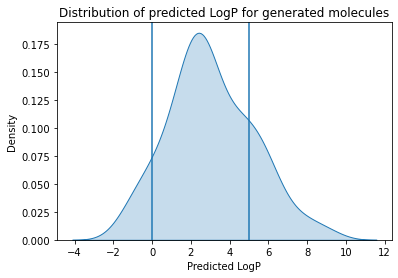

Sample trajectories:
C#CCOCCCCC                      
C=C(O)NC(=O)S                   
C=CC(=O)CCCCO                   
C=CC=CC=CCCC                    
C=CC=CCC(Cl)COCCCC              
Policy Iteration: 6


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [08:33<00:00, 34.20s/it]


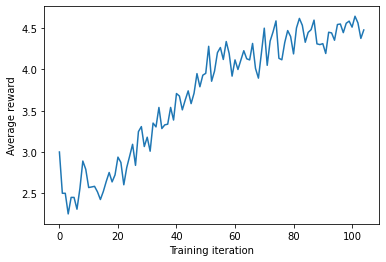

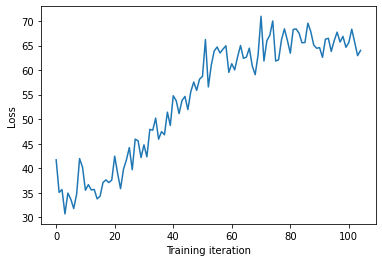

Calculating predictions...: 100%|██████████| 212/212 [00:00<00:00, 826.84it/s]


Percentage of predictions within drug-like region: 0.5027322404371585
Proportion of valid SMILES: 0.4575
Average Mol Weight: 158.167065324


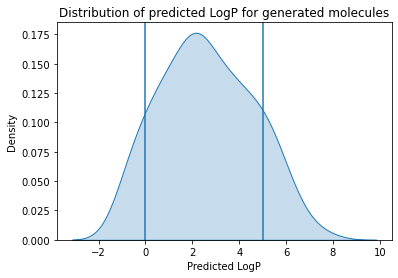

Sample trajectories:
C#CCC(C)C                       
C#CCOCCC(C)=CCl                 
C=CC=CCC(C)CCCC                 
C=CCC(=O)OCO                    
C=CCC(C)CO                      
Policy Iteration: 7


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [07:37<00:00, 30.52s/it]


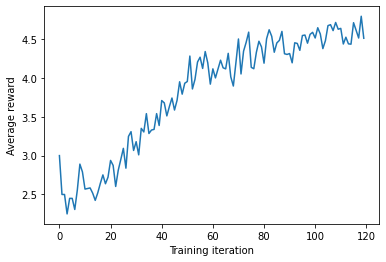

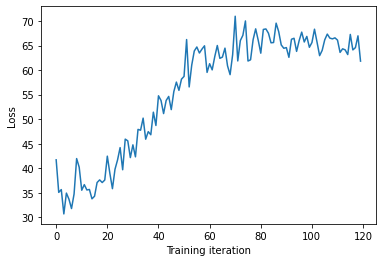

Calculating predictions...: 100%|██████████| 212/212 [00:00<00:00, 936.69it/s]


Percentage of predictions within drug-like region: 0.5989010989010989
Proportion of valid SMILES: 0.455
Average Mol Weight: 148.08359725499997


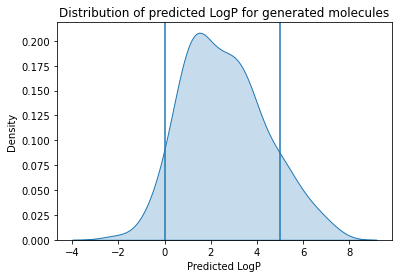

Sample trajectories:
C                            
C#CCC(C)CC(C)Cl              
C1CCCCC1                     
C=C(N)CC(O)CC                
C=CC(C)COCCC                 
Policy Iteration: 8


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [06:57<00:00, 27.85s/it]


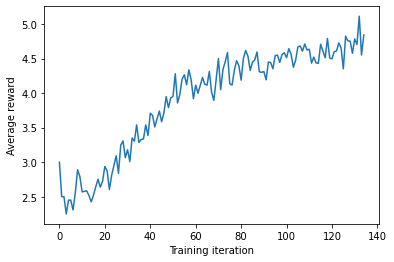

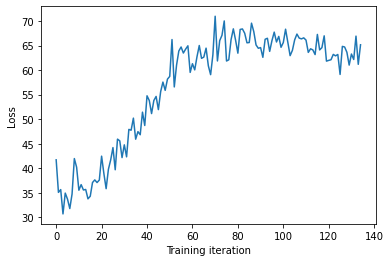

Calculating predictions...: 100%|██████████| 238/238 [00:00<00:00, 930.02it/s]


Percentage of predictions within drug-like region: 0.5560747663551402
Proportion of valid SMILES: 0.535
Average Mol Weight: 180.589331948


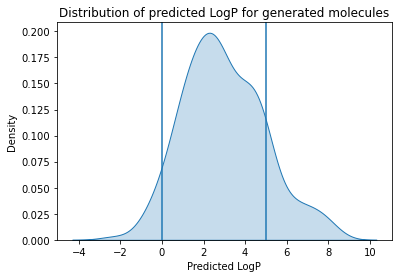

Sample trajectories:
C#CCCCCCCC#CCCCCN(C)C            
CC(=O)CCCC(Cl)C=CCO              
CC(=O)OCSC(O)C=CCO               
CC(C)(O)CCCCCCC(N)CCO            
CC(C)=CC(C)CO                    
Policy Iteration: 9


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [06:36<00:00, 26.45s/it]


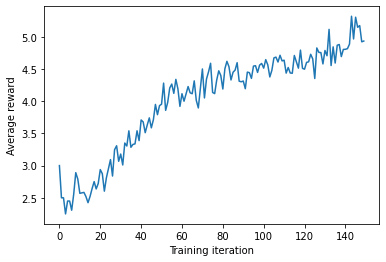

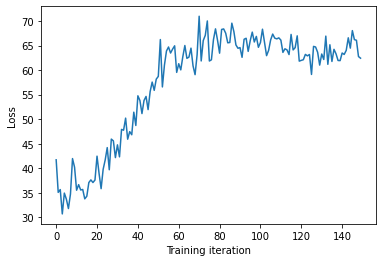

Calculating predictions...: 100%|██████████| 236/236 [00:00<00:00, 721.66it/s]


Percentage of predictions within drug-like region: 0.6161137440758294
Proportion of valid SMILES: 0.5275
Average Mol Weight: 173.177964356


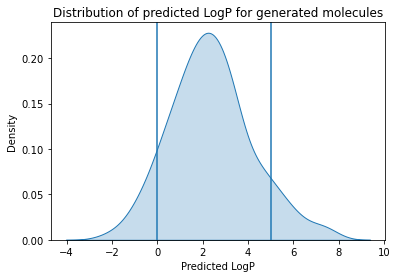

Sample trajectories:
C=CC(C=CC(C)CNCCN)CF          
C=CCC(CO)CC(C)C(O)O           
C=CCC(CO)CCO                  
C=CCC=CCCC(O)C(O)CC           
C=CCCCCCCCCNO                 
Policy Iteration: 10


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [06:34<00:00, 26.31s/it]


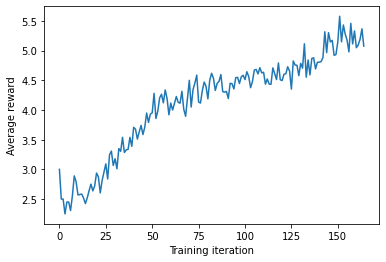

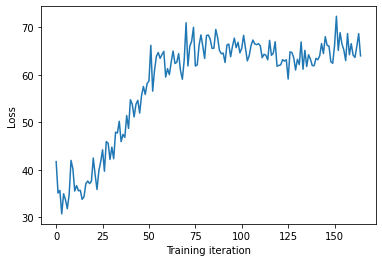

Calculating predictions...: 100%|██████████| 262/262 [00:00<00:00, 766.41it/s]


Percentage of predictions within drug-like region: 0.6176470588235294
Proportion of valid SMILES: 0.595
Average Mol Weight: 195.615589068


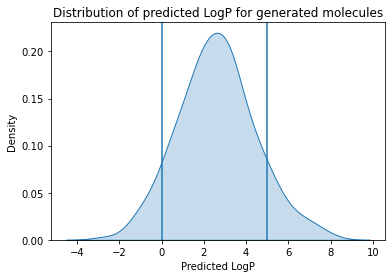

Sample trajectories:
CC(=O)CCC(C)O                  
CC(C)(CO)CCCCCl                
CC(C)C(C)C(C)CCOCO             
CC(C)CCC(C)C                   
CC(C)CCCCCCC(O)CCCC(C)O        
Policy Iteration: 11


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:55<00:00, 23.69s/it]


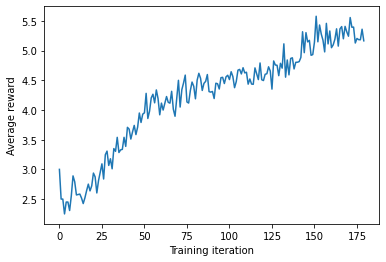

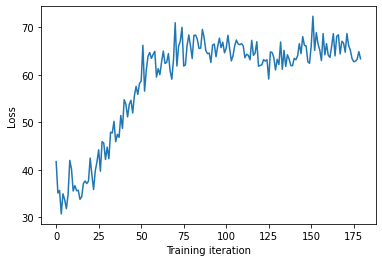

Calculating predictions...: 100%|██████████| 283/283 [00:00<00:00, 766.83it/s]


Percentage of predictions within drug-like region: 0.5916030534351145
Proportion of valid SMILES: 0.655
Average Mol Weight: 186.198365452


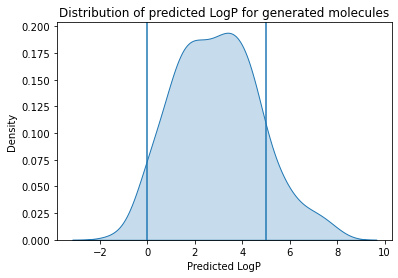

Sample trajectories:
C                             
C#CCCCCC(O)CCC(O)OC           
C=C(CCCC)C(C)C                
C=C(CCO)CCC(C)C               
C=C(F)CNOC(C)CC(C)CCCCC       
Policy Iteration: 12


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:50<00:00, 23.37s/it]


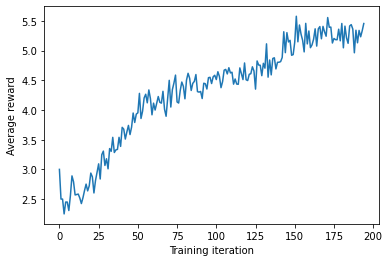

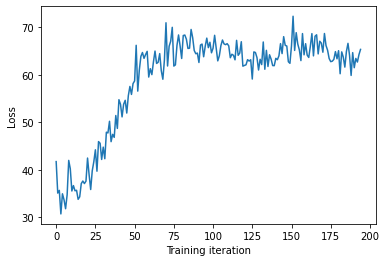

Calculating predictions...: 100%|██████████| 290/290 [00:00<00:00, 897.76it/s]


Percentage of predictions within drug-like region: 0.6
Proportion of valid SMILES: 0.65
Average Mol Weight: 173.15977160199998


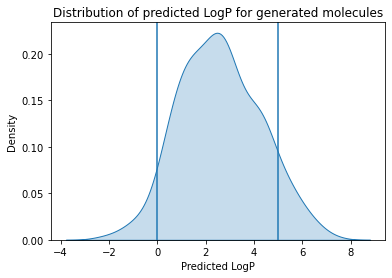

Sample trajectories:
C#CCCCCNCCCCN               
C=CC=CCCC(=O)OC             
C=CCC(O)(Cl)CNCl            
CC                          
CC(=O)CC(C)CC(C)CO          
Policy Iteration: 13


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:48<00:00, 23.26s/it]


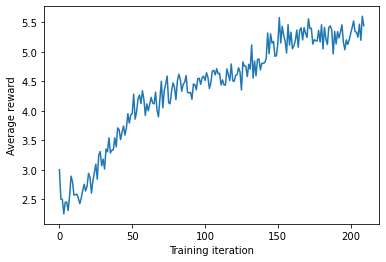

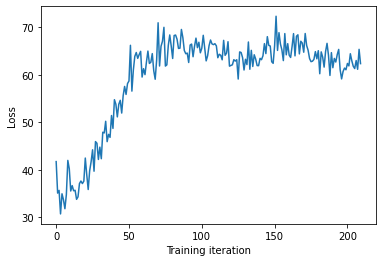

Calculating predictions...: 100%|██████████| 289/289 [00:00<00:00, 820.64it/s]


Percentage of predictions within drug-like region: 0.5888888888888889
Proportion of valid SMILES: 0.675
Average Mol Weight: 174.161979944


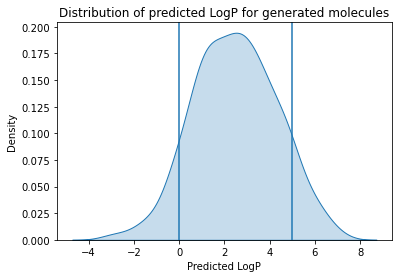

Sample trajectories:
C#CCCCOCCCCCC              
C#CCCOC(C)CCCCC            
CC                         
CC#CCCCCCCCO               
CC(C)(O)CCCCCO             
Policy Iteration: 14


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:47<00:00, 23.17s/it]


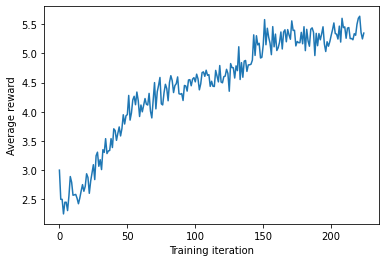

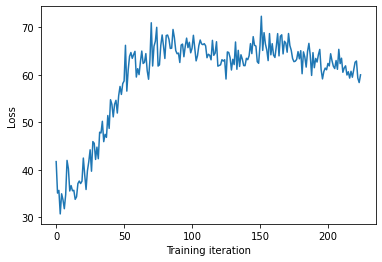

Calculating predictions...: 100%|██████████| 288/288 [00:00<00:00, 778.93it/s]


Percentage of predictions within drug-like region: 0.6529850746268657
Proportion of valid SMILES: 0.67
Average Mol Weight: 173.657396086


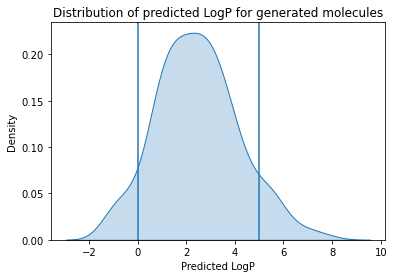

Sample trajectories:
CC(=O)CC(C)CN            
CC(Br)CCCCCF             
CC(C)C(C)C(O)CCl         
CC(C)C(C)COCCCCO         
CC(C)CC(O)CCCO           
Policy Iteration: 15


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:02<00:00, 20.15s/it]


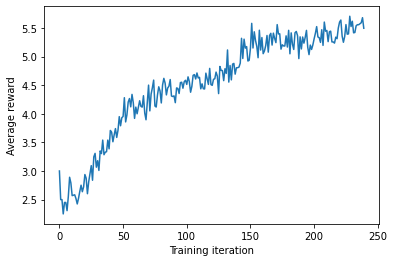

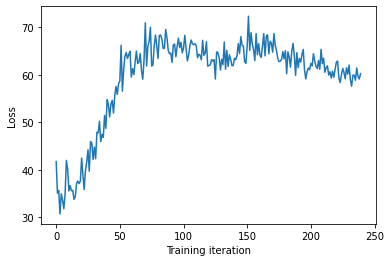

Calculating predictions...: 100%|██████████| 290/290 [00:00<00:00, 711.50it/s]


Percentage of predictions within drug-like region: 0.6728624535315985
Proportion of valid SMILES: 0.6725
Average Mol Weight: 162.125594436


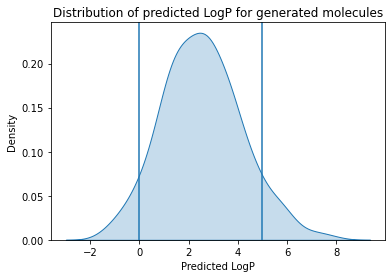

Sample trajectories:
C                        
C#CCCCOC(CO)CCCCCC       
C#CNCC(O)CCC(F)CCC       
CC                       
CC(=O)C(C)CCCC(O)OO      
Policy Iteration: 16


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:32<00:00, 22.13s/it]


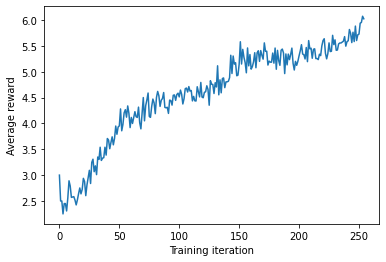

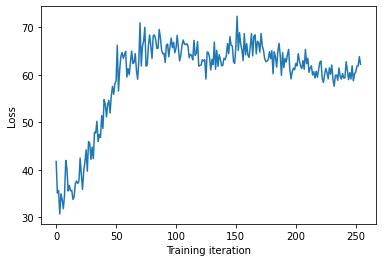

Calculating predictions...: 100%|██████████| 305/305 [00:00<00:00, 740.80it/s]


Percentage of predictions within drug-like region: 0.6870748299319728
Proportion of valid SMILES: 0.735
Average Mol Weight: 176.1412445


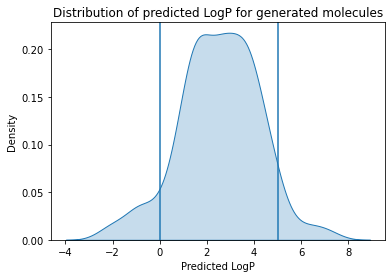

Sample trajectories:
C=CC(C)C(C)C(C)Cl          
C=CCCC(C)OCCOC             
C=CCCOC(O)CCC(O)OCC=CCC(C)O
CC#CCCCCCCOCCC             
CC(=O)CNCCCC(C)O           
Policy Iteration: 17


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:49<00:00, 23.31s/it]


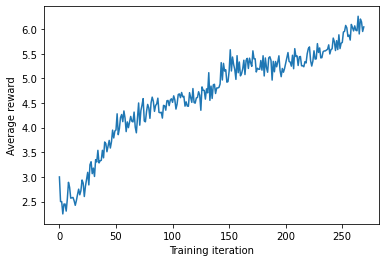

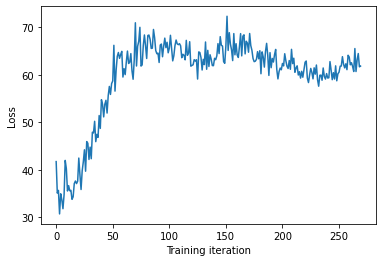

Calculating predictions...: 100%|██████████| 311/311 [00:00<00:00, 908.64it/s]


Percentage of predictions within drug-like region: 0.6421404682274248
Proportion of valid SMILES: 0.7475
Average Mol Weight: 190.156894564


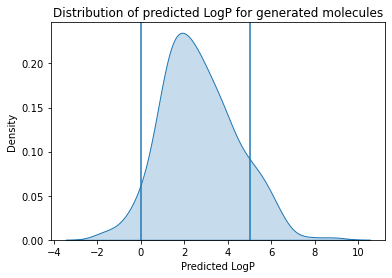

Sample trajectories:
C=CCCOC(C)COC                
CC(=O)CC(C)C(F)CC=N          
CC(C)CC(C)CO                 
CC(C)CCCO                    
CC(C)CCN                     
Policy Iteration: 18


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:48<00:00, 23.25s/it]


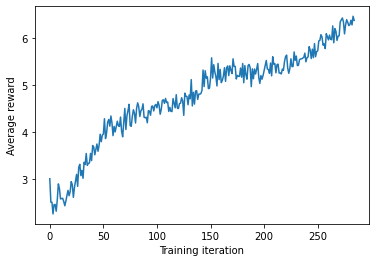

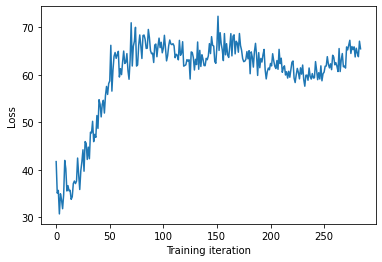

Calculating predictions...: 100%|██████████| 309/309 [00:00<00:00, 765.22it/s]


Percentage of predictions within drug-like region: 0.7250859106529209
Proportion of valid SMILES: 0.7275
Average Mol Weight: 188.177630008


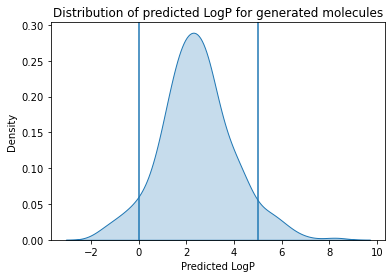

Sample trajectories:
C=CC=CC(O)CC(C)CCCO      
CC                       
CC#CC(C)CCCOOOC          
CC(C)CCCCCC(CO)CO        
CC(C)CCCCCCCOCCO         
Policy Iteration: 19


Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jonas\Documents\GitHub\ReLeaSE-multiobjective\./release\data.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Policy gradient...: 100%|██████████| 15/15 [05:43<00:00, 22.92s/it]


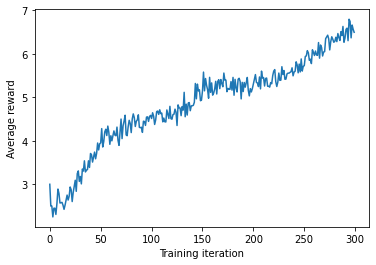

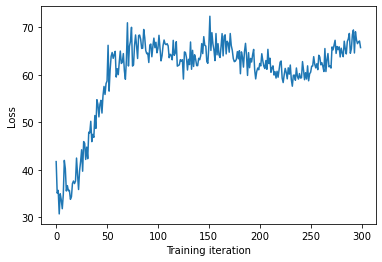

Calculating predictions...: 100%|██████████| 330/330 [00:00<00:00, 789.67it/s]


Percentage of predictions within drug-like region: 0.7019230769230769
Proportion of valid SMILES: 0.78
Average Mol Weight: 200.177630008


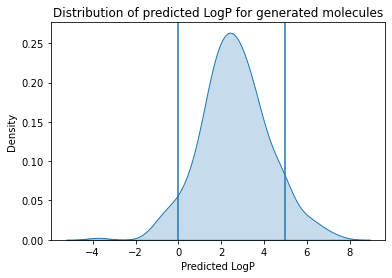

Sample trajectories:
C=CCCCCOCC(O)CCCOC       
CC(C)C(C)CCl             
CC(C)CC(Br)CCN           
CC(C)CCCOCCCOCO          
CC(C)COCCCCCCCO          


In [42]:
percentage = []
avg_weight = []

for i in range(n_iterations):
    print('Policy Iteration:', i)
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
    
    
    
    smiles_cur, prediction_cur, p, w = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate,
                                                     batch_s)
    
    percentage.append(p)
    avg_weight.append(w)
    
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

We can take a look at some of the generated SMILES:

In [43]:
smiles_cur

['C=CCCCCOCC(O)CCCOC       ',
 'CC(C)C(C)CCl             ',
 'CC(C)CC(Br)CCN           ',
 'CC(C)CCCOCCCOCO          ',
 'CC(C)COCCCCCCCO          ',
 'CC(CCO)CCCCO             ',
 'CC(CCO)CCOCO             ',
 'CC(CCOCO)C(Cl)CCN        ',
 'CC(CO)CCC(O)C(O)C(O)CCCO ',
 'CC(CO)CCCCCC(C)CO        ',
 'CC(CO)CCCCCCCO           ',
 'CC(CO)CCCCCCOCCCOCO      ',
 'CC(CO)OCCCOCCO           ',
 'CC(O)CCOCCCOCCO          ',
 'CC1CCC(O)COCCCC=CCNC1O   ',
 'CC=CCC(O)CCCCCO          ',
 'CC=CCCCCNC(C)CCOC        ',
 'CCC#CCCCOCCC             ',
 'CCC(C)(N)C(C)C(O)OC      ',
 'CCC(C)CC(C)C(O)CC(C)O    ',
 'CCC(C)CCC(C)OCO          ',
 'CCC(C)CCC(O)CCC(N)CC     ',
 'CCC(C)CCC(O)OCCC(O)O     ',
 'CCC(C)CCCCCC(O)OCO       ',
 'CCC(C)CCOCCCO            ',
 'CCC(C)CNCNC=CP           ',
 'CCC(C)OCCCOCO            ',
 'CCC(CC)CCO               ',
 'CCC(CCCO)CCCC=CCO        ',
 'CCC(CNC)COCCCCCO         ',
 'CCC(CO)NC                ',
 'CCC(Cl)CCCC(O)CCCO       ',
 'CCC(Cl)CCCCC(C)CCCO      ',
 'CCC(Cl)N

And we can also see how the percentage and the average weight evolved over time:

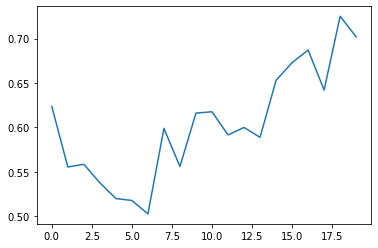

In [48]:
plt.plot(range(20), percentage)

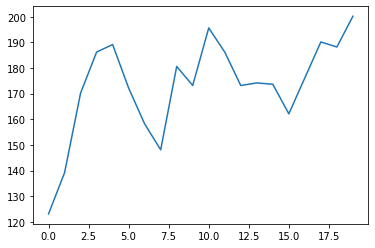

In [49]:
plt.plot(range(20), avg_weight)